In [295]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle


path = os.getcwd().split(os.sep + 'network')[0]
if path not in sys.path:
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.data as data

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [296]:
def plot_0():

    fig, ax = plt.subplots(2,2, figsize=(24,20))
    ax[0,0].plot(aln.t, aln.rates_exc[0,:], lw=1, c='red', label='Node 0 exc')
    ax[0,1].plot(aln.t, aln.rates_inh[0,:], lw=1, c='blue', label='Node 0 inh')
    ax[1,0].plot(aln.t, aln.rates_exc[1,:], lw=1, c='red', label='Node 1 exc')
    ax[1,1].plot(aln.t, aln.rates_inh[1,:], lw=1, c='blue', label='Node 1 inh')


    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Rate [Hz]")
            ax[i,j].set_xlim(0, aln.t[-1])
            
    plt.show()


In [297]:
def plot(control0, state0, target=None):

    fig, ax = plt.subplots(4,2, figsize=(12,14))
    
    print(control0.shape[2], control0.shape[2] * aln.params.dt)
    
    t_array = np.arange(0., round(control0.shape[2] * aln.params.dt, 1), aln.params.dt)
    print(t_array.shape, state0.shape)

    ax[0,0].plot(t_array, state0[0,0,:], lw=1, c='red', label='Node 0 exc')
    ax[0,1].plot(t_array, state0[0,1,:], lw=1, c='blue', label='Node 0 inh')
    ax[1,0].plot(t_array, state0[1,0,:], lw=1, c='red', label='Node 1 exc')
    ax[1,1].plot(t_array, state0[1,1,:], lw=1, c='blue', label='Node 1 inh')

    if type(target) != type(None):
        ax[0,0].plot(t_array, target[0,0,:], linestyle='--', c='red')
        ax[0,1].plot(t_array, target[0,1,:], linestyle='--', c='blue')
        ax[1,0].plot(t_array, target[1,0,:], linestyle='--', c='red')
        ax[1,1].plot(t_array, target[1,1,:], linestyle='--', c='blue')

    ax[2,0].plot(t_array, control0[0,0,:], c='red', label='Node 0 exc')
    ax[2,1].plot(t_array, control0[0,1,:], c='blue', label='Node 0 inh')
    ax[3,0].plot(t_array, control0[1,0,:], c='red', label='Node 1 exc')
    ax[3,1].plot(t_array, control0[1,1,:], c='blue', label='Node 1 inh')

    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Rate [Hz]")
            ax[i,j].set_xlim(0, aln.params.duration)

    for i in range(2,4):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Control [nA]")
            ax[i,j].set_xlim(0, aln.params.duration)

    plt.show()
    
def setinit(initvars, N):
    state_vars = aln.state_vars
    init_vars = aln.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                for n in range(N):
                    if aln.params[init_vars[iv]].ndim == 1:
                        aln.params[init_vars[iv]][n] = initvars[n,sv]
                    else:
                        aln.params[init_vars[iv]][n,:] = initvars[n,sv]
                        
def setinitzero():
    state_vars = aln.state_vars
    init_vars = aln.init_vars
    N = aln.params.N
    for iv in range(len(init_vars)):
        for n in range(N):
            if aln.params[init_vars[iv]].ndim == 1:
                aln.params[init_vars[iv]][n] = 0.
            else:
                aln.params[init_vars[iv]][n,:] = 0.

In [298]:
def initmodel(mue, mui, cmat, dmat):
    aln = ALNModel(Cmat = cmat, Dmat = dmat)
    aln.params.Dmat = dmat
    
    N = aln.params.N
    aln.params.sigma_ou = 0.
    aln.params.a = 0.
    aln.params.b = 0.

    aln.params.ext_exc_current = 0.
    aln.params.ext_inh_current = 0.

    aln.params.mue_ext_mean = mue * 5.
    aln.params.mui_ext_mean = mui * 5.
    
    aln.params.de = 0.
    aln.params.di = 0.
    
    return aln

In [299]:
cmat = 1. * np.array( [[0., 0.], [1., 0.]] )
dmat = 0. * np.array( [[1., 1.], [1., 1.]] )
aln = initmodel(0., 0., cmat, dmat)
N = aln.params.N

tol = 1e-10
start_step = 10.

max_cntrl = [5., 5., 100., 100., 100., 100.]
min_cntrl = [-5., -5., 0., 0., 0., 0.]

dur_pre = 10.
dur_post = 10.
trans_time = 0.9
n_pre = int(dur_pre / aln.params.dt)
n_post = int(dur_post / aln.params.dt)

c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

In [300]:
state_vars = aln.state_vars
init_vars = aln.init_vars

In [311]:
mu_e = np.arange(0.25,0.52,0.01)
mu_i = np.arange(0.2,0.41,0.01)
state = np.zeros (( len(mu_e), len(mu_i) ))

from scipy.signal import find_peaks_cwt

"""
low 0 - black,
high 1 - red
bi 2 - green
osc 3 - yellow

BLUE
low high - 4.1
low bi - 4.2
low osc - 4.3

PURPLE
high low - 5.0
high bi - 5.2
high osc - 5.3

ORANGE
bi low - 6.0
bi high - 6.1
bi osc - 6.3

osc low - 7.0
osc high - 7.1
osc bi - 7.2

misc - -1

"""

limit_low = 3.
limit_std_osc = 0.1
diff_bi = 3.

amp = 0.5

x_, y_, c_ = [], [], []

for i in range(len(mu_i)):
        
    for e in range(len(mu_e)): 
            
        print('-----', e, i)
        aln = initmodel(mu_e[e], mu_i[i], cmat, dmat)
        setinitzero()
        
        x_.append(mu_e[e])
        y_.append(mu_i[i])
        
        aln.params.duration = 40 * 1000.
        
        t_ = int(round( 200. / aln.params.dt, 1) )
        t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
        t0 = int( t1 - t_ )
        
        control0 = aln.getZeroControl()
        control0[:,0,:int(2*t_)] = amp
        control0[:,0,t1:int(t1 + 2.*t_)] = - amp
        aln.run(control=control0)
        
        #plot_0()
        
        if False:
            fig, ax = plt.subplots(2,4, figsize=(24,20))
            ax[0,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[0,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
            ax[1,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[1,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
            ax[0,1].plot(aln.t[-t_:], aln.rates_exc[0,-t_:], lw=1, c='red', label='Node 0 exc')
            ax[1,1].plot(aln.t[-t_:], aln.rates_exc[1,-t_:], lw=1, c='red', label='Node 0 exc')

            ax[0,2].plot(aln.t[t0:t0+t_], aln.rates_inh[0,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
            ax[1,2].plot(aln.t[t0:t0+t_], aln.rates_inh[1,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
            ax[0,3].plot(aln.t[-t_:], aln.rates_inh[0,-t_:], lw=1, c='red', label='Node 0 exc')
            ax[1,3].plot(aln.t[-t_:], aln.rates_inh[1,-t_:], lw=1, c='red', label='Node 0 exc')

            plt.show()  
            
        rates_exc = [ aln.rates_exc[0,-t_:], aln.rates_exc[0,t0:int(t0+t_)],
                     aln.rates_exc[1,-t_:], aln.rates_exc[1,t0:int(t0+t_)] ]
        
        std_dev = np.array( [np.std(aln.rates_exc[0,-t_:]), np.std(aln.rates_exc[0,t0:int(t0+t_)]),
            np.std(aln.rates_exc[1,-t_:]), np.std(aln.rates_exc[1,t0:int(t0+t_)])] )
        
        print(std_dev)
        
        # small amplitude osc
        small_osc = False
        for k in range(len(std_dev)):
            if std_dev[k] < limit_std_osc:
                peaks_ind = find_peaks_cwt(rates_exc[k], np.arange(1, 10))
                if len(peaks_ind) > 3 and len(peaks_ind) < len(rates_exc[k]) / 3.:
                    print("small amp oscillations?")
                    state[e,i] = -1
                    c_.append('gray')
                    small_osc = True
                    break
        if small_osc:
            continue
            
        
        # low/ high
        if ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) < diff_bi
            and np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < diff_bi
            and np.amax(std_dev) < limit_std_osc ):
            if aln.rates_exc[0,-1] < limit_low:
                print("monostable low state")
                state[e,i] = 0
                c_.append('black')
                continue
            else:
                print("monostable high state")
                state[e,i] = 1
                c_.append('red')
                continue
        # bistable
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) > diff_bi
            and np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) > diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) > diff_bi
            and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) > diff_bi
            and np.amax(std_dev) < 1. ):
            print("bistable ")
            state[e,i] = 2
            c_.append('green')
            continue
        # osc
        elif ( np.amin(std_dev) > limit_std_osc and np.abs(std_dev[0] - std_dev[1]) < 0.5
            and np.abs(std_dev[2] - std_dev[3]) < 0.5 ):
            print("monostable oscillations")
            state[e,i] = 3
            c_.append('yellow')
            continue
            
        # 0 low
        if ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) < diff_bi
            and aln.rates_exc[0,-1] < limit_low
            and std_dev[0] < limit_std_osc and std_dev[1] < limit_std_osc ):
            print("node 0 low")
            state[e,i] = 4.
            c_.append('blue')
            
            # 1 high
            if ( np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < 3. * diff_bi
                and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < 3. * diff_bi
                and aln.rates_exc[1,-1] > limit_low
                and std_dev[2] < limit_std_osc and std_dev[3] < limit_std_osc ):
                print("node 1 high")
                state[e,i] += 0.1
                
            # 1 bi
            elif ( np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) > diff_bi
                and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) > diff_bi
                and std_dev[2] < limit_std_osc and std_dev[3] < limit_std_osc ):
                print("node 1 bistable ")
                state[e,i] += 0.2
                c_.pop()
                c_.append('pink')            
                
            # 1 osc
            elif ( std_dev[2] > limit_std_osc and std_dev[3] > limit_std_osc
                and np.abs(std_dev[2] - std_dev[3]) < 0.5 ):
                print("node 1 osc")
                state[e,i] += 0.3
            
        # 0 high
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) < diff_bi
            and aln.rates_exc[0,-1] > limit_low
            and std_dev[0] < limit_std_osc and std_dev[1] < limit_std_osc ):
            print("node 0 high")
            state[e,i] = 5.
            c_.append('purple')
            
        # 0 bi
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) > diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) > diff_bi
            and ( aln.rates_exc[0,-1] > limit_low or aln.rates_exc[0,t0-1] > limit_low )
            and std_dev[0] < limit_std_osc and std_dev[1] < limit_std_osc ):
            print("node 0 bi")
            state[e,i] = 6.
            c_.append('orange')
            
            # node 1 low
            if ( np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < diff_bi
                and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < diff_bi
                and aln.rates_exc[1,-1] < limit_low
                and std_dev[2] < limit_std_osc and std_dev[3] < limit_std_osc ):
                print("node 1 low")
            
            # 1 high
            elif ( np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < 3. * diff_bi
                and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < 3. * diff_bi
                and aln.rates_exc[1,-1] > limit_low
                and std_dev[2] < limit_std_osc and std_dev[3] < limit_std_osc ):
                print("node 1 high")
                state[e,i] += 0.1
                
            # 1 osc
            elif ( std_dev[2] > limit_std_osc and std_dev[3] > limit_std_osc
                and np.abs(std_dev[2] - std_dev[3]) < 0.5 ):
                print("node 1 osc")
                state[e,i] += 0.3
            
        else:
            print("MISC")
            state[e,i] = -1
            c_.append('gray')

----- 0 0
[1.02647283 1.03017595 3.55123493 3.69587842]
monostable oscillations
----- 1 0
[1.68046378 1.68679788 4.95236361 5.12059548]
monostable oscillations
----- 2 0
[2.40100112 2.47722574 5.98448187 6.18293577]
monostable oscillations
----- 3 0
[3.1762154  3.08840179 6.89013857 6.63339199]
monostable oscillations
----- 4 0
[3.58618371 3.59567497 6.85395474 6.89963527]
monostable oscillations
----- 5 0
[3.7766018  3.78177209 6.54830312 6.57675654]
monostable oscillations
----- 6 0
[3.54340377 3.54368379 5.35977477 5.36585783]
monostable oscillations
----- 7 0
[2.816466   2.8059234  3.31058617 3.25474923]
monostable oscillations
----- 8 0
[1.41498693 1.43808335 1.14199221 1.13891687]
monostable oscillations
----- 9 0
[1.77635684e-15 1.77635684e-15 5.32907052e-15 5.32907052e-15]
monostable high state
----- 10 0
[5.32907052e-15 5.32907052e-15 0.00000000e+00 0.00000000e+00]
monostable high state
----- 11 0
[0.00000000e+00 0.00000000e+00 3.55271368e-15 3.55271368e-15]
monostable high st

[3.55271368e-15 3.55271368e-15 1.06581410e-14 1.06581410e-14]
monostable high state
----- 13 3
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 14 3
[1.0658141e-14 1.0658141e-14 1.0658141e-14 1.0658141e-14]
monostable high state
----- 15 3
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 16 3
[7.10542736e-15 7.10542736e-15 0.00000000e+00 0.00000000e+00]
monostable high state
----- 17 3
[0.00000000e+00 0.00000000e+00 7.10542736e-15 0.00000000e+00]
monostable high state
----- 18 3
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 19 3
[7.10542736e-15 1.42108547e-14 1.42108547e-14 7.10542736e-15]
monostable high state
----- 20 3
[2.13162821e-14 2.13162821e-14 7.10542736e-15 7.10542736e-15]
monostable high state
----- 21 3
[1.42108547e-14 1.42108547e-14 1.42108547e-14 7.10542736e-15]
monostable high state
----- 22 3
[0.00000000e+00 1.42108547e-14 0.00000000e+00 1.421085

monostable high state
----- 21 6
[0.00000000e+00 1.42108547e-14 0.00000000e+00 7.10542736e-15]
monostable high state
----- 22 6
[1.42108547e-14 0.00000000e+00 7.10542736e-15 7.10542736e-15]
monostable high state
----- 23 6
[2.13162821e-14 7.10542736e-15 1.42108547e-14 1.42108547e-14]
monostable high state
----- 24 6
[2.13162821e-14 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 25 6
[1.42108547e-14 2.13162821e-14 1.42108547e-14 2.13162821e-14]
monostable high state
----- 26 6
[7.10542736e-15 0.00000000e+00 7.10542736e-15 7.10542736e-15]
monostable high state
----- 0 7
[0.00000000e+00 0.00000000e+00 1.38777878e-17 1.38777878e-17]
monostable low state
----- 1 7
[0.00000000e+00 0.00000000e+00 2.77555756e-17 2.77555756e-17]
monostable low state
----- 2 7
[2.77555756e-17 2.77555756e-17 8.32667268e-17 8.32667268e-17]
monostable low state
----- 3 7
[5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17]
monostable low state
----- 4 7
[5.55111512e-17 5.55111512

[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.46944695e-18]
monostable low state
----- 2 10
[6.93889390e-18 0.00000000e+00 3.46944695e-18 0.00000000e+00]
monostable low state
----- 3 10
[1.38777878e-17 1.38777878e-17 1.38777878e-17 1.38777878e-17]
monostable low state
----- 4 10
[1.38777878e-17 1.38777878e-17 0.00000000e+00 0.00000000e+00]
monostable low state
----- 5 10
[1.38777878e-17 1.38777878e-17 1.38777878e-17 1.38777878e-17]
monostable low state
----- 6 10
[0. 0. 0. 0.]
monostable low state
----- 7 10
[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.55111512e-17]
monostable low state
----- 8 10
[5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17]
monostable low state
----- 9 10
[5.55111512e-17 5.55111512e-17 1.11022302e-16 1.11022302e-16]
monostable low state
----- 10 10
[2.22044605e-16 2.22044605e-16 0.00000000e+00 2.22044605e-16]
monostable low state
----- 11 10
[2.22044605e-16 1.11022302e-16 2.22044605e-16 1.11022302e-16]
monostable low state
----- 12 10
[3.33066907

[0.00000000e+00 0.00000000e+00 4.16333634e-17 4.16333634e-17]
monostable low state
----- 10 13
[2.77555756e-17 2.77555756e-17 2.77555756e-17 2.77555756e-17]
monostable low state
----- 11 13
[2.77555756e-17 2.77555756e-17 5.55111512e-17 5.55111512e-17]
monostable low state
----- 12 13
[5.55111512e-17 5.55111512e-17 5.55111512e-17 1.11022302e-16]
monostable low state
----- 13 13
[0.00000000e+00 0.00000000e+00 1.11022302e-16 1.11022302e-16]
monostable low state
----- 14 13
[0.00000000e+00 7.10542736e-15 1.11022302e-16 7.10542736e-15]
bistable 
----- 15 13
[1.11022302e-16 3.55271368e-15 1.11022302e-16 3.55271368e-15]
bistable 
----- 16 13
[3.33066907e-16 7.10542736e-15 4.44089210e-16 7.10542736e-15]
bistable 
----- 17 13
[0.00000000e+00 3.55271368e-15 7.10542736e-15 7.10542736e-15]
node 0 bi
node 1 high
----- 18 13
[1.42108547e-14 1.42108547e-14 0.00000000e+00 0.00000000e+00]
monostable high state
----- 19 13
[0.00000000e+00 7.10542736e-15 0.00000000e+00 7.10542736e-15]
monostable high sta

[1.11022302e-16 0.00000000e+00 5.55111512e-17 1.06581410e-14]
bistable 
----- 17 16
[5.55111512e-17 7.10542736e-15 0.00000000e+00 7.10542736e-15]
bistable 
----- 18 16
[1.11022302e-16 7.10542736e-15 2.22044605e-16 7.10542736e-15]
bistable 
----- 19 16
[3.33066907e-16 0.00000000e+00 0.00000000e+00 1.42108547e-14]
bistable 
----- 20 16
[2.22044605e-16 1.42108547e-14 1.42108547e-14 7.10542736e-15]
node 0 bi
node 1 high
----- 21 16
[7.10542736e-15 1.42108547e-14 1.42108547e-14 0.00000000e+00]
monostable high state
----- 22 16
[1.42108547e-14 0.00000000e+00 7.10542736e-15 1.42108547e-14]
monostable high state
----- 23 16
[2.13162821e-14 1.42108547e-14 0.00000000e+00 1.42108547e-14]
monostable high state
----- 24 16
[1.42108547e-14 0.00000000e+00 7.10542736e-15 2.13162821e-14]
monostable high state
----- 25 16
[0.00000000e+00 7.10542736e-15 1.42108547e-14 2.13162821e-14]
monostable high state
----- 26 16
[7.10542736e-15 0.00000000e+00 1.42108547e-14 2.13162821e-14]
monostable high state
----

monostable high state
----- 25 19
[0.00000000e+00 0.00000000e+00 7.10542736e-15 0.00000000e+00]
monostable high state
----- 26 19
[1.42108547e-14 7.10542736e-15 1.42108547e-14 1.42108547e-14]
monostable high state
----- 0 20
[6.46234854e-27 1.93870456e-26 1.29246971e-26 6.46234854e-27]
monostable low state
----- 1 20
[5.16987883e-26 0.00000000e+00 2.58493941e-26 7.75481824e-26]
monostable low state
----- 2 20
[2.06795153e-25 4.13590306e-25 4.13590306e-25 0.00000000e+00]
monostable low state
----- 3 20
[0.00000000e+00 0.00000000e+00 1.65436123e-24 1.65436123e-24]
monostable low state
----- 4 20
[3.30872245e-24 0.00000000e+00 3.30872245e-24 6.61744490e-24]
monostable low state
----- 5 20
[1.32348898e-23 0.00000000e+00 1.32348898e-23 0.00000000e+00]
monostable low state
----- 6 20
[5.29395592e-23 7.94093388e-23 0.00000000e+00 5.29395592e-23]
monostable low state
----- 7 20
[3.17637355e-22 0.00000000e+00 2.11758237e-22 3.17637355e-22]
monostable low state
----- 8 20
[8.47032947e-22 4.23516

In [312]:
with open('state_space.pickle','wb') as f:
    pickle.dump([[x_, y_, c_, state],[x_1, y_1, c_1, state1]] , f)

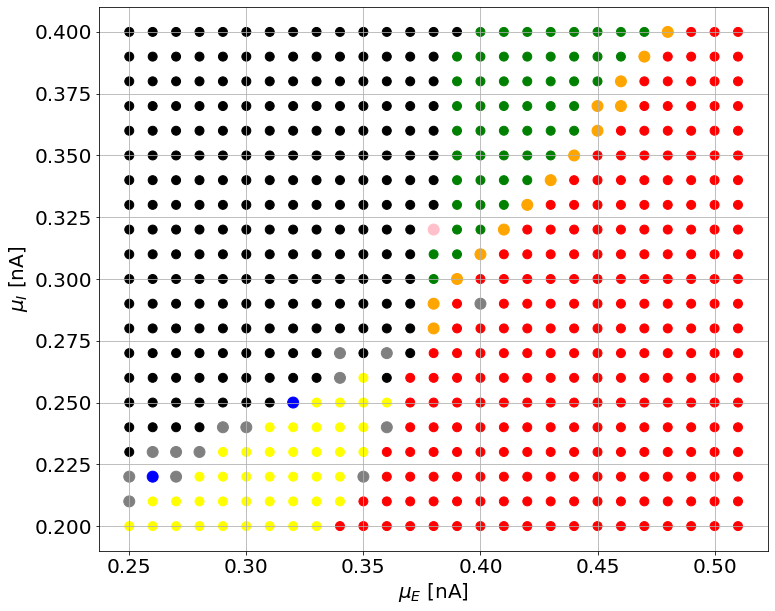

In [313]:
s_ = []
for i in range(len(x_)):
    if c_[i] in ['black', 'red', 'yellow', 'green']:
        s_.append(80.)
    else:
        s_.append(120.)

fig, ax = plt.subplots(figsize=(12,10))
scatter = ax.scatter(x_, y_, c=c_, s=s_)


ax.set_xlabel(r'$\mu_E$ [nA]')
ax.set_ylabel(r'$\mu_I$ [nA]')#, alpha=0.3,cmap='viridis')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
plt.show()

In [314]:
mu_e = np.arange(0.25,0.52,0.01)
mu_i = np.arange(0.2,0.41,0.01)
state1 = np.zeros (( len(mu_e), len(mu_i) ))

from scipy.signal import find_peaks_cwt

"""
low 0 - black,
high 1 - red
bi 2 - green
osc 3 - yellow

BLUE
low high - 4.1
low bi - 4.2
low osc - 4.3

PURPLE
high low - 5.0
high bi - 5.2
high osc - 5.3

ORANGE
bi low - 6.0
bi high - 6.1
bi osc - 6.3

osc low - 7.0
osc high - 7.1
osc bi - 7.2

misc - -1

"""

limit_low = 3.
limit_std_osc = 0.1
diff_bi = 3.

amp = 0.1

x_1, y_1, c_1 = [], [], []

for i in range(len(mu_i)):
        
    for e in range(len(mu_e)): 
            
        print('-----', e, i)
        aln = initmodel(mu_e[e], mu_i[i], cmat, dmat)
        setinitzero()
        
        x_1.append(mu_e[e])
        y_1.append(mu_i[i])
        
        aln.params.duration = 40 * 1000.
        
        t_ = int(round( 200. / aln.params.dt, 1) )
        t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
        t0 = int( t1 - t_ )
        
        control0 = aln.getZeroControl()
        control0[:,0,:int(2*t_)] = amp
        control0[:,0,t1:int(t1 + 2.*t_)] = - amp
        aln.run(control=control0)
        
        #plot_0()
        
        if False:
            fig, ax = plt.subplots(2,4, figsize=(24,20))
            ax[0,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[0,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
            ax[1,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[1,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
            ax[0,1].plot(aln.t[-t_:], aln.rates_exc[0,-t_:], lw=1, c='red', label='Node 0 exc')
            ax[1,1].plot(aln.t[-t_:], aln.rates_exc[1,-t_:], lw=1, c='red', label='Node 0 exc')

            ax[0,2].plot(aln.t[t0:t0+t_], aln.rates_inh[0,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
            ax[1,2].plot(aln.t[t0:t0+t_], aln.rates_inh[1,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
            ax[0,3].plot(aln.t[-t_:], aln.rates_inh[0,-t_:], lw=1, c='red', label='Node 0 exc')
            ax[1,3].plot(aln.t[-t_:], aln.rates_inh[1,-t_:], lw=1, c='red', label='Node 0 exc')

            plt.show()  
            
        rates_exc = [ aln.rates_exc[0,-t_:], aln.rates_exc[0,t0:int(t0+t_)],
                     aln.rates_exc[1,-t_:], aln.rates_exc[1,t0:int(t0+t_)] ]
        
        std_dev = np.array( [np.std(aln.rates_exc[0,-t_:]), np.std(aln.rates_exc[0,t0:int(t0+t_)]),
            np.std(aln.rates_exc[1,-t_:]), np.std(aln.rates_exc[1,t0:int(t0+t_)])] )
        
        print(std_dev)
        
        # small amplitude osc
        small_osc = False
        for k in range(len(std_dev)):
            if std_dev[k] < limit_std_osc:
                peaks_ind = find_peaks_cwt(rates_exc[k], np.arange(1, 10))
                if len(peaks_ind) > 3 and len(peaks_ind) < len(rates_exc[k]) / 3.:
                    print("small amp oscillations?")
                    state[e,i] = -1
                    c_1.append('gray')
                    small_osc = True
                    break
        if small_osc:
            continue
            
        
        # low/ high
        if ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) < diff_bi
            and np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < diff_bi
            and np.amax(std_dev) < limit_std_osc ):
            if aln.rates_exc[0,-1] < limit_low:
                print("monostable low state")
                state1[e,i] = 0
                c_1.append('black')
                continue
            else:
                print("monostable high state")
                state[e,i] = 1
                c_1.append('red')
                continue
        # bistable
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) > diff_bi
            and np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) > diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) > diff_bi
            and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) > diff_bi
            and np.amax(std_dev) < 1. ):
            print("bistable ")
            state1[e,i] = 2
            c_1.append('green')
            continue
        elif ( np.amin(std_dev) > limit_std_osc and np.abs(std_dev[0] - std_dev[1]) < 0.5
            and np.abs(std_dev[2] - std_dev[3]) < 0.5 ):
            print("monostable oscillations")
            state1[e,i] = 3
            c_1.append('yellow')
            continue
            
        # 0 low
        if ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) < diff_bi
            and aln.rates_exc[0,-1] < limit_low
            and std_dev[0] < limit_std_osc and std_dev[1] < limit_std_osc ):
            print("node 0 low")
            state1[e,i] = 4.
            c_1.append('blue')
            
        # 0 high
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) < diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) < diff_bi
            and aln.rates_exc[0,-1] > limit_low
            and std_dev[0] < limit_std_osc and std_dev[1] < limit_std_osc ):
            print("node 0 high")
            state1[e,i] = 5.
            c_1.append('purple')
            
        # 0 bi
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,t0-1]) > diff_bi
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,t0-1]) > diff_bi
            and ( aln.rates_exc[0,-1] > limit_low or aln.rates_exc[0,t0-1] > limit_low )
            and std_dev[0] < limit_std_osc and std_dev[1] < limit_std_osc ):
            print("node 0 bi")
            state1[e,i] = 6.
            c_1.append('orange')
            
            # node 1 low
            if ( np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < diff_bi
                and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < diff_bi
                and aln.rates_exc[1,-1] < limit_low
                and std_dev[2] < limit_std_osc and std_dev[3] < limit_std_osc ):
                print("node 1 low")
            
            # 0 high
            elif ( np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,t0-1]) < 3. * diff_bi
                and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,t0-1]) < 3. * diff_bi
                and aln.rates_exc[1,-1] > limit_low
                and std_dev[2] < limit_std_osc and std_dev[3] < limit_std_osc ):
                print("node 1 high")
                state1[e,i] += 0.1
                
            
            
        else:
            print("MISC")
            state1[e,i] = -1
            c_1.append('gray')

----- 0 0
[1.04597033 1.05241373 3.53676235 3.59733194]
monostable oscillations
----- 1 0
[1.67235486 1.73749096 4.94168531 5.08655644]
monostable oscillations
----- 2 0
[2.40462514 2.39149434 5.97728584 5.95829573]
monostable oscillations
----- 3 0
[3.18114603 3.12488319 6.76710452 6.89084742]
monostable oscillations
----- 4 0
[3.58182661 3.65981178 6.92370272 7.11847135]
monostable oscillations
----- 5 0
[3.77748993 3.78447994 6.54516235 6.53193275]
monostable oscillations
----- 6 0
[3.55084033 3.54528741 5.3773365  5.30133548]
monostable oscillations
----- 7 0
[2.79950688 2.795676   3.32121384 3.32790762]
monostable oscillations
----- 8 0
[1.40112488 1.42126812 1.15168939 1.14567625]
monostable oscillations
----- 9 0
[1.77635684e-15 1.77635684e-15 1.77635684e-15 1.77635684e-15]
monostable high state
----- 10 0
[5.32907052e-15 5.32907052e-15 0.00000000e+00 0.00000000e+00]
monostable high state
----- 11 0
[0.00000000e+00 0.00000000e+00 7.10542736e-15 3.55271368e-15]
monostable high st

[8.8817842e-16 8.8817842e-16 0.0000000e+00 0.0000000e+00]
monostable high state
----- 12 3
[0.00000000e+00 3.55271368e-15 3.55271368e-15 1.06581410e-14]
monostable high state
----- 13 3
[3.55271368e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 14 3
[0.00000000e+00 1.06581410e-14 3.55271368e-15 1.06581410e-14]
monostable high state
----- 15 3
[3.55271368e-15 7.10542736e-15 1.42108547e-14 7.10542736e-15]
monostable high state
----- 16 3
[7.10542736e-15 7.10542736e-15 0.00000000e+00 0.00000000e+00]
monostable high state
----- 17 3
[0.00000000e+00 0.00000000e+00 7.10542736e-15 0.00000000e+00]
monostable high state
----- 18 3
[7.10542736e-15 7.10542736e-15 0.00000000e+00 7.10542736e-15]
monostable high state
----- 19 3
[7.10542736e-15 1.42108547e-14 1.42108547e-14 7.10542736e-15]
monostable high state
----- 20 3
[1.42108547e-14 2.13162821e-14 7.10542736e-15 7.10542736e-15]
monostable high state
----- 21 3
[1.42108547e-14 1.42108547e-14 1.42108547e-14 7.105427

[7.10542736e-15 7.10542736e-15 0.00000000e+00 7.10542736e-15]
monostable high state
----- 20 6
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 21 6
[0.00000000e+00 1.42108547e-14 0.00000000e+00 7.10542736e-15]
monostable high state
----- 22 6
[1.42108547e-14 0.00000000e+00 7.10542736e-15 7.10542736e-15]
monostable high state
----- 23 6
[2.13162821e-14 7.10542736e-15 1.42108547e-14 1.42108547e-14]
monostable high state
----- 24 6
[2.13162821e-14 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 25 6
[1.42108547e-14 2.13162821e-14 1.42108547e-14 2.13162821e-14]
monostable high state
----- 26 6
[7.10542736e-15 0.00000000e+00 7.10542736e-15 7.10542736e-15]
monostable high state
----- 0 7
[0.00000000e+00 0.00000000e+00 1.38777878e-17 0.00000000e+00]
monostable low state
----- 1 7
[0.00000000e+00 2.77555756e-17 2.77555756e-17 5.55111512e-17]
monostable low state
----- 2 7
[2.77555756e-17 2.77555756e-17 0.00000000e+00 5.5511151

[0.00000000e+00 1.42108547e-14 7.10542736e-15 7.10542736e-15]
monostable high state
----- 0 10
[8.67361738e-19 1.73472348e-18 0.00000000e+00 8.67361738e-19]
monostable low state
----- 1 10
[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.46944695e-18]
monostable low state
----- 2 10
[6.93889390e-18 0.00000000e+00 3.46944695e-18 0.00000000e+00]
monostable low state
----- 3 10
[1.38777878e-17 0.00000000e+00 1.38777878e-17 0.00000000e+00]
monostable low state
----- 4 10
[1.38777878e-17 1.38777878e-17 0.00000000e+00 1.38777878e-17]
monostable low state
----- 5 10
[1.38777878e-17 0.00000000e+00 1.38777878e-17 2.77555756e-17]
monostable low state
----- 6 10
[0. 0. 0. 0.]
monostable low state
----- 7 10
[0.00000000e+00 5.55111512e-17 0.00000000e+00 1.11022302e-16]
monostable low state
----- 8 10
[5.55111512e-17 5.55111512e-17 0.00000000e+00 0.00000000e+00]
monostable low state
----- 9 10
[5.55111512e-17 5.55111512e-17 1.11022302e-16 2.22044605e-16]
monostable low state
----- 10 10
[2.22044605e

[0.00000000e+00 1.73472348e-18 3.46944695e-18 3.46944695e-18]
monostable low state
----- 7 13
[0.00000000e+00 3.46944695e-18 0.00000000e+00 0.00000000e+00]
monostable low state
----- 8 13
[6.93889390e-18 1.38777878e-17 2.08166817e-17 0.00000000e+00]
monostable low state
----- 9 13
[0.00000000e+00 1.38777878e-17 4.16333634e-17 1.38777878e-17]
monostable low state
----- 10 13
[2.77555756e-17 5.55111512e-17 2.77555756e-17 0.00000000e+00]
monostable low state
----- 11 13
[2.77555756e-17 2.77555756e-17 5.55111512e-17 5.55111512e-17]
monostable low state
----- 12 13
[5.55111512e-17 5.55111512e-17 1.11022302e-16 1.11022302e-16]
monostable low state
----- 13 13
[0.00000000e+00 0.00000000e+00 1.11022302e-16 0.00000000e+00]
monostable low state
----- 14 13
[0.00000000e+00 7.10542736e-15 2.22044605e-16 7.10542736e-15]
bistable 
----- 15 13
[2.22044605e-16 3.55271368e-15 0.00000000e+00 3.55271368e-15]
bistable 
----- 16 13
[3.55271368e-15 7.10542736e-15 0.00000000e+00 7.10542736e-15]
monostable hi

[1.04083409e-17 1.38777878e-17 6.93889390e-18 6.93889390e-18]
monostable low state
----- 13 16
[6.9388939e-18 6.9388939e-18 0.0000000e+00 0.0000000e+00]
monostable low state
----- 14 16
[0.00000000e+00 3.55271368e-15 4.16333634e-17 0.00000000e+00]
bistable 
----- 15 16
[2.77555756e-17 0.00000000e+00 0.00000000e+00 7.10542736e-15]
bistable 
----- 16 16
[1.06581410e-14 0.00000000e+00 3.55271368e-15 1.06581410e-14]
monostable high state
----- 17 16
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 18 16
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 19 16
[1.42108547e-14 0.00000000e+00 0.00000000e+00 1.42108547e-14]
monostable high state
----- 20 16
[0.00000000e+00 1.42108547e-14 7.10542736e-15 7.10542736e-15]
monostable high state
----- 21 16
[7.10542736e-15 1.42108547e-14 1.42108547e-14 0.00000000e+00]
monostable high state
----- 22 16
[1.42108547e-14 0.00000000e+00 7.10542736e-15 1.42108547e-14]
monostab

[0.00000000e+00 0.00000000e+00 7.10542736e-15 7.10542736e-15]
monostable high state
----- 20 19
[7.10542736e-15 7.10542736e-15 7.10542736e-15 7.10542736e-15]
monostable high state
----- 21 19
[0.00000000e+00 7.10542736e-15 1.42108547e-14 7.10542736e-15]
monostable high state
----- 22 19
[7.10542736e-15 7.10542736e-15 7.10542736e-15 0.00000000e+00]
monostable high state
----- 23 19
[1.42108547e-14 1.42108547e-14 7.10542736e-15 1.42108547e-14]
monostable high state
----- 24 19
[7.10542736e-15 7.10542736e-15 7.10542736e-15 2.13162821e-14]
monostable high state
----- 25 19
[0.00000000e+00 0.00000000e+00 7.10542736e-15 0.00000000e+00]
monostable high state
----- 26 19
[1.42108547e-14 7.10542736e-15 1.42108547e-14 1.42108547e-14]
monostable high state
----- 0 20
[6.46234854e-27 1.93870456e-26 1.29246971e-26 6.46234854e-27]
monostable low state
----- 1 20
[5.16987883e-26 0.00000000e+00 2.58493941e-26 7.75481824e-26]
monostable low state
----- 2 20
[2.06795153e-25 4.13590306e-25 4.13590306e-25

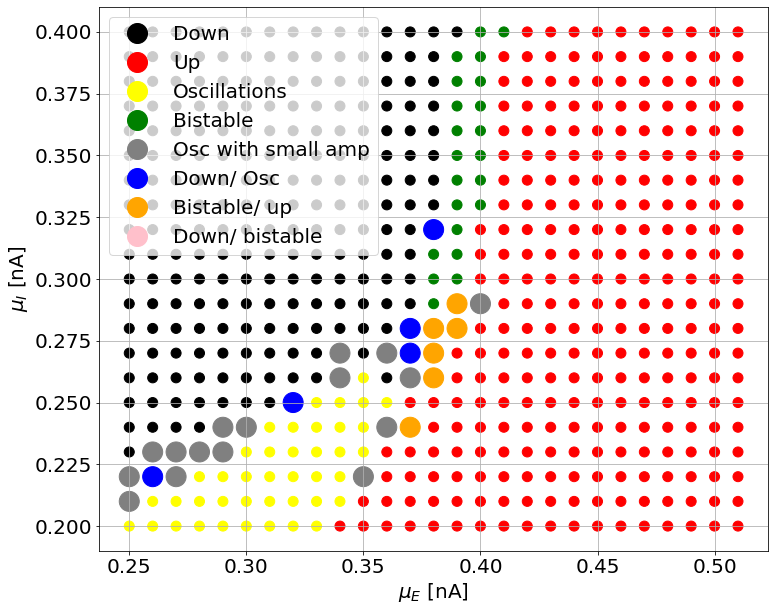

In [315]:
s_ = []
for i in range(len(x_1)):
    if c_1[i] in ['black', 'red', 'yellow', 'green']:
        s_.append(100.)
    else:
        s_.append(400.)

fig, ax = plt.subplots(figsize=(12,10))
scatter = ax.scatter(x_1, y_1, c=c_1, s=s_, alpha=1.)

down = plt.Line2D([-1], [-1], marker='o', linestyle='', color='black', markersize=20)
up = plt.Line2D([-1], [-1], marker='o', linestyle='', color='red', markersize=20)
osc = plt.Line2D([-1], [-1], marker='o', linestyle='', color='yellow', markersize=20)
bi = plt.Line2D([-1], [-1], marker='o', linestyle='', color='green', markersize=20)
sa_osc = plt.Line2D([-1], [-1], marker='o', linestyle='', color='grey', markersize=20)
low_osc = plt.Line2D([-1], [-1], marker='o', linestyle='', color='blue', markersize=20)
bi_up = plt.Line2D([-1], [-1], marker='o', linestyle='', color='orange', markersize=20)
low_bi = plt.Line2D([-1], [-1], marker='o', linestyle='', color='pink', markersize=20)


plt.legend( [down, up, osc, bi, sa_osc, low_osc, bi_up, low_bi],
            ['Down', 'Up', 'Oscillations', 'Bistable', 'Osc with small amp',
             'Down/ Osc', 'Bistable/ up', 'Down/ bistable'] ,
           numpoints=1, loc='upper left', ncol=1, fontsize=20)

ax.set_xlabel(r'$\mu_E$ [nA]')
ax.set_ylabel(r'$\mu_I$ [nA]')#, alpha=0.3,cmap='viridis')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
plt.show()

In [289]:
c_[27], c_1[27] = 'yellow', 'yellow'
c_[119], c_1[119] = 'yellow', 'yellow'
c_[171], c_1[171] = 'blue', 'blue'
c_[258], c_1[258] = 'red', 'red'
c_[312], c_1[312] = 'orange', 'orange'
c_[340], c_1[340] = 'orange', 'orange'
c_[368], c_1[368] = 'orange', 'orange'
c_[396], c_1[396] = 'orange', 'orange'

c_[424], c_1[424] = 'orange', 'orange'
c_[452], c_1[452] = 'orange', 'orange'
c_[479], c_1[479] = 'orange', 'orange'
c_[480], c_1[480] = 'orange', 'orange'

c_[507], c_1[507] = 'orange', 'orange'
c_[535], c_1[535] = 'orange', 'orange'
c_[563], c_1[563] = 'orange', 'orange'

c_[120], c_1[120] = 'orange', 'orange'
c_[175], c_1[175] = 'orange', 'orange'
c_[229], c_1[229] = 'orange', 'orange'

c_[202], c_1[202] = 'orange', 'orange'
c_[230], c_1[230] = 'orange', 'orange'
c_[257], c_1[257] = 'orange', 'orange'

c_[256], c_1[256] = 'orange', 'orange'
c_[284], c_1[284] = 'orange', 'orange'

c_[201], c_1[201] = 'orange', 'orange'
c_[228], c_1[228] = 'pink', 'pink'
c_[337], c_1[337] = 'pink', 'pink'

In [272]:
# 85: 0,1, osc, osc, at different amplitude
# 174: bistable/ small amp
# 202, 230, 257 only works with certain inputs
# 55: 0: low/low, 1: small osc/ osc
c_[85], c_1[85] = 'cyan', 'cyan'
c_[174], c_1[174] = 'cyan', 'cyan'
c_[55], c_1[55] = 'cyan', 'cyan'

In [316]:
for i in range(len(x_)):
    if c_[i] != c_1[i]:
        print('differing color: ', i, c_[i], c_1[i])
        #if c_[i] == 'green' and c_1[i] == 'red':
        #    c_[i], c_1[i] = 'green', 'green'

differing color:  85 yellow gray
differing color:  120 red orange
differing color:  174 red gray
differing color:  175 red orange
differing color:  201 black blue
differing color:  202 red orange
differing color:  228 black blue
differing color:  230 red orange
differing color:  256 orange green
differing color:  257 red orange
differing color:  284 orange green
differing color:  312 orange red
differing color:  337 pink blue
differing color:  339 green red
differing color:  340 orange red
differing color:  367 green red
differing color:  368 orange red
differing color:  394 green red
differing color:  395 green red
differing color:  396 orange red
differing color:  421 green red
differing color:  422 green red
differing color:  423 green red
differing color:  424 orange red
differing color:  448 green red
differing color:  449 green red
differing color:  450 green red
differing color:  451 green red
differing color:  452 orange red
differing color:  475 green red
differing color:  476

----- 55 0.26 0.22000000000000003


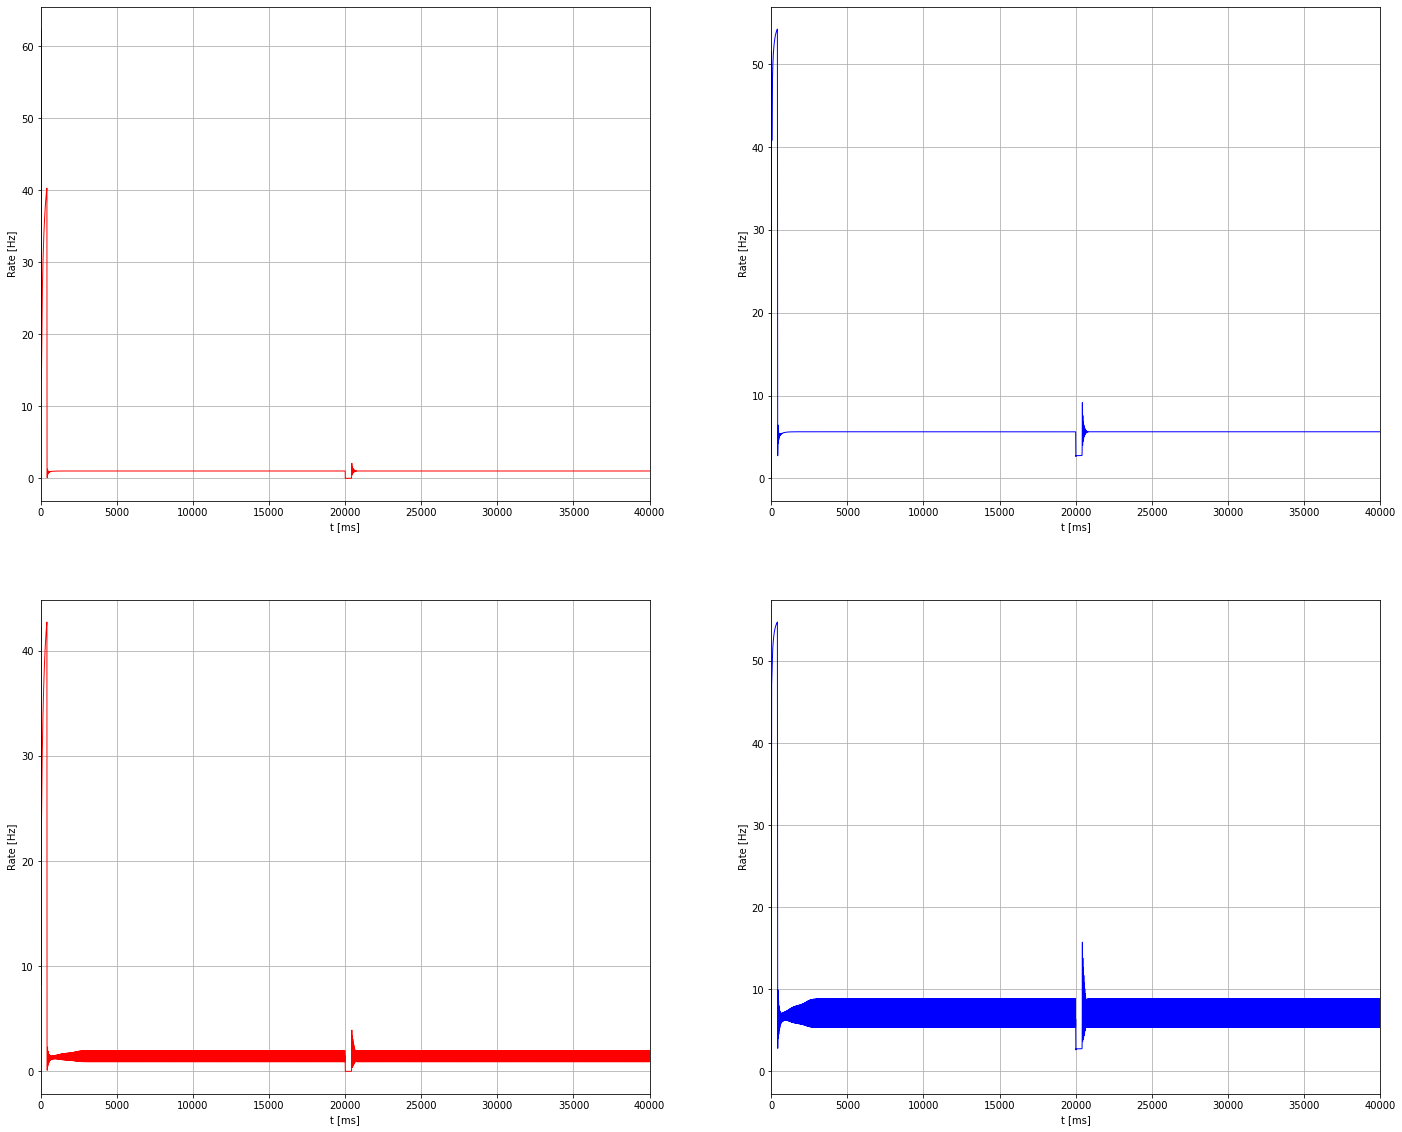

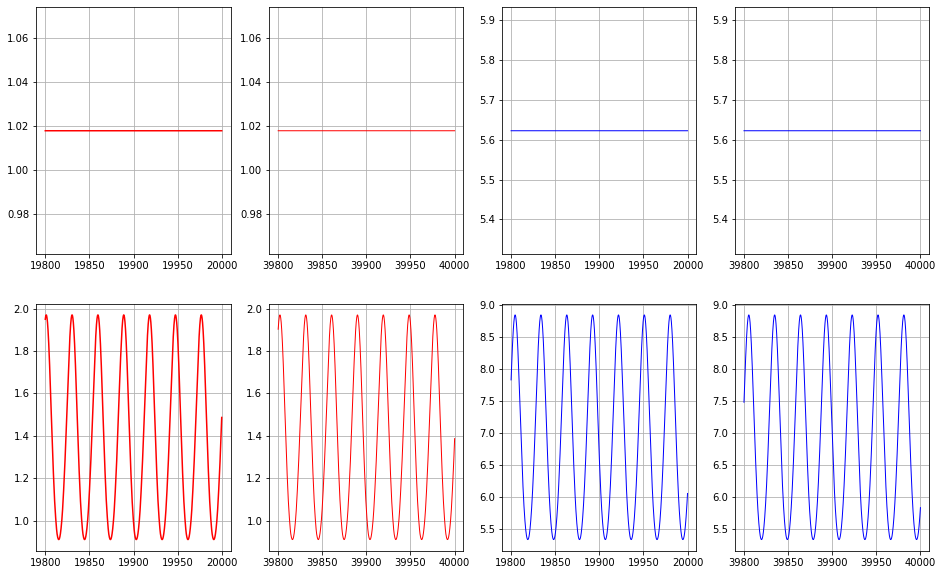

In [309]:
### examples:
i_ = [55, 56, 85, 171, 174, 228, 256]

amp = 1.

for i in i_:
    
    if i > 55:
        break

    print('-----', i, x_[i], y_[i])
    aln = initmodel(x_[i], y_[i], cmat, dmat)

    aln.params.duration = 40 * 1000.

    t_ = int(round( 200. / aln.params.dt, 1) )
    t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
    t0 = int( t1 - t_ )

    control0 = aln.getZeroControl()
    control0[:,0,:int(2*t_)] = amp
    control0[:,0,t1:int(t1 + 2.*t_)] = - amp
    aln.run(control=control0)

    plot_0()

    if i in [55, 56, 85, 174]:

        fig, ax = plt.subplots(2,4, figsize=(16,10))
        ax[0,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[0,t0:int(t0+t_)], c='red')
        ax[1,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[1,t0:int(t0+t_)], c='red')
        ax[0,1].plot(aln.t[-t_:], aln.rates_exc[0,-t_:], lw=1, c='red')
        ax[1,1].plot(aln.t[-t_:], aln.rates_exc[1,-t_:], lw=1, c='red')

        ax[0,2].plot(aln.t[t0:t0+t_], aln.rates_inh[0,t0:t0+t_], lw=1, c='blue')
        ax[1,2].plot(aln.t[t0:t0+t_], aln.rates_inh[1,t0:t0+t_], lw=1, c='blue')
        ax[0,3].plot(aln.t[-t_:], aln.rates_inh[0,-t_:], lw=1, c='blue')
        ax[1,3].plot(aln.t[-t_:], aln.rates_inh[1,-t_:], lw=1, c='blue')

        plt.show()

----- 337 0.3800000000000001 0.3200000000000001


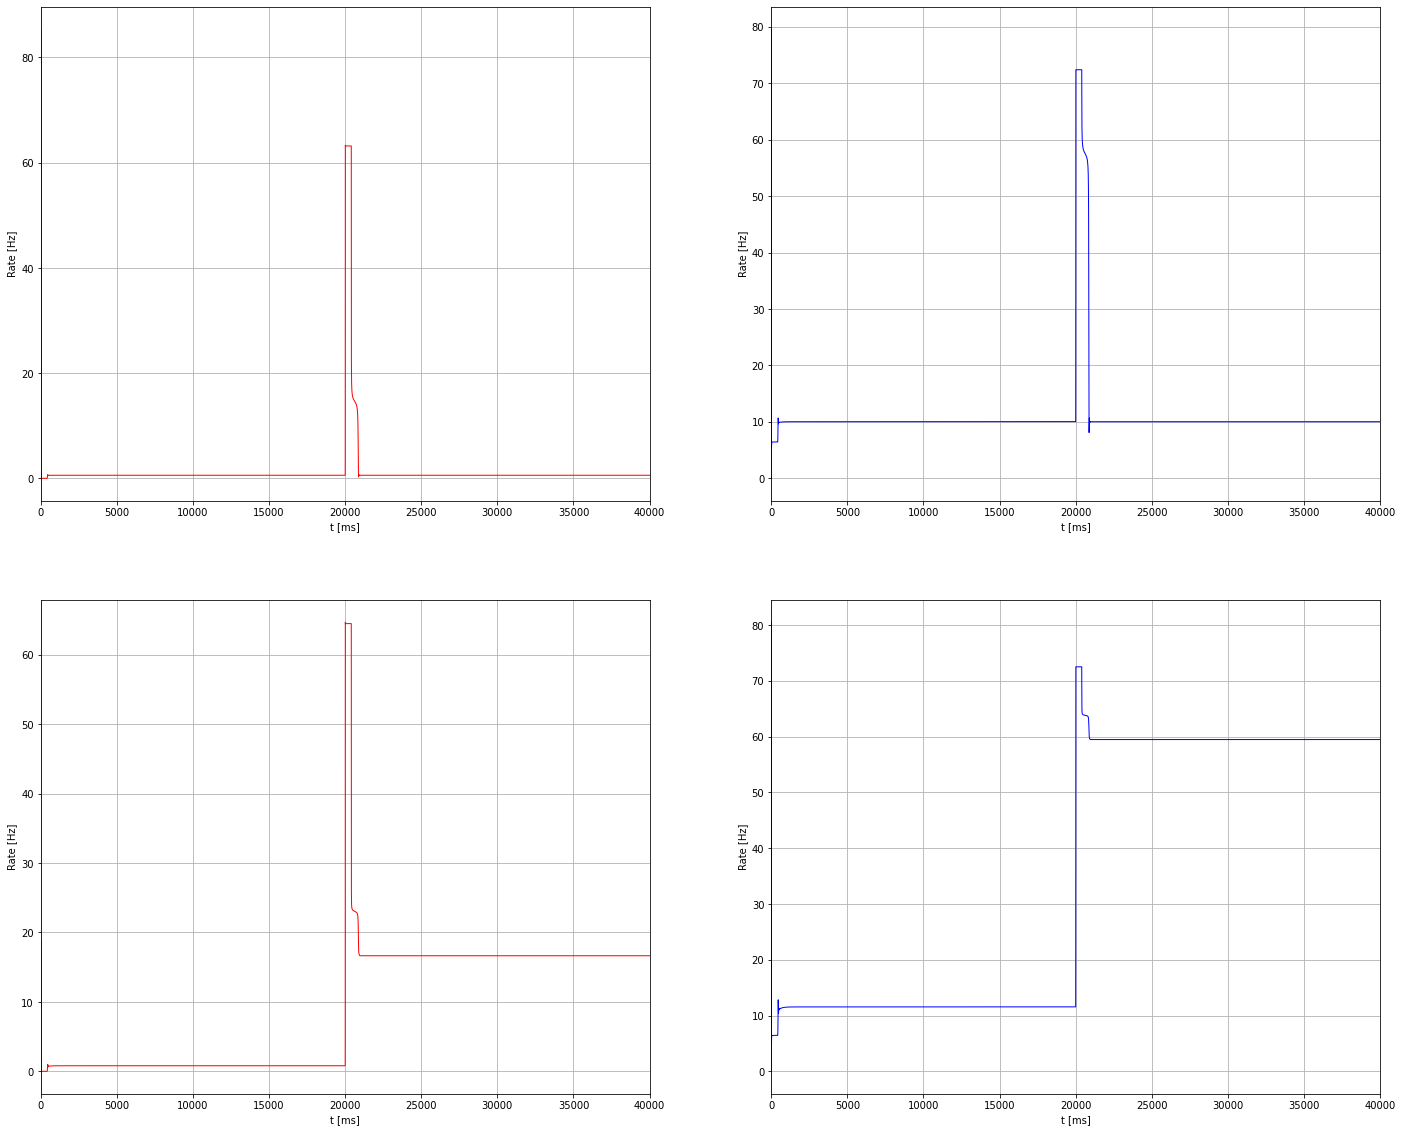

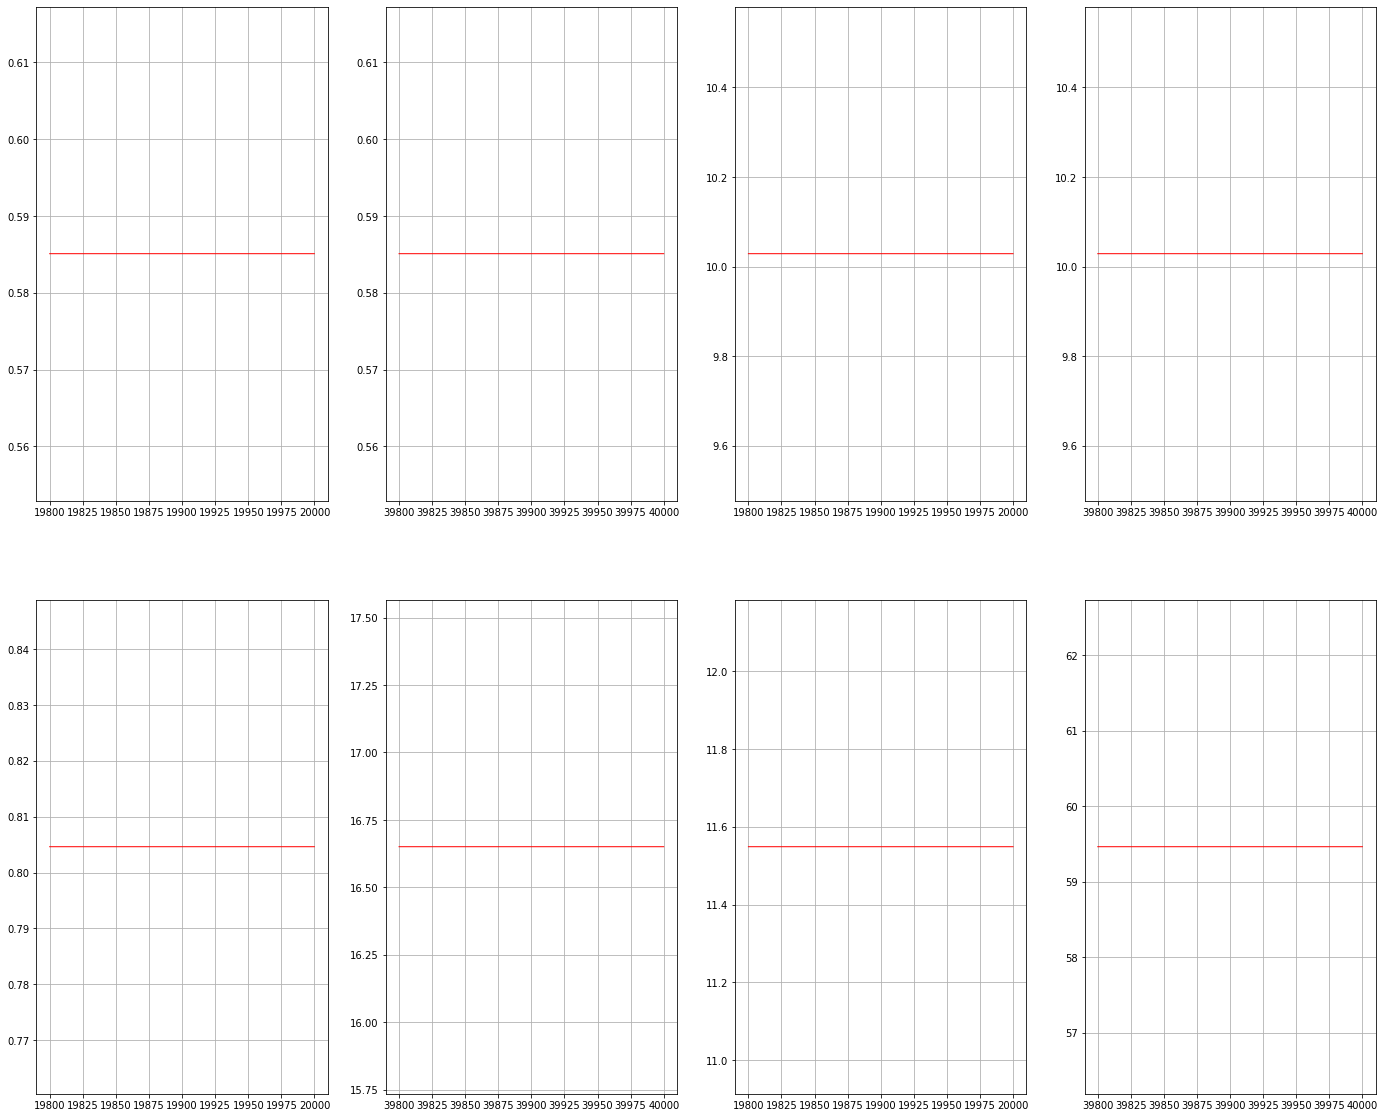

In [284]:
amp = -1.

for i in range(len(x_)):
    
    if i < 300:
        continue
        
    if c_[i] == 'blue':

        print('-----', i, x_[i], y_[i])
        aln = initmodel(x_[i], y_[i], cmat, dmat)

        aln.params.duration = 40 * 1000.

        t_ = int(round( 200. / aln.params.dt, 1) )
        t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
        t0 = int( t1 - t_ )

        control0 = aln.getZeroControl()
        control0[:,0,:int(2*t_)] = amp
        control0[:,0,t1:int(t1 + 2.*t_)] = - amp
        aln.run(control=control0)

        plot_0()

        fig, ax = plt.subplots(2,4, figsize=(24,20))
        ax[0,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[0,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
        ax[1,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[1,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
        ax[0,1].plot(aln.t[-t_:], aln.rates_exc[0,-t_:], lw=1, c='red', label='Node 0 exc')
        ax[1,1].plot(aln.t[-t_:], aln.rates_exc[1,-t_:], lw=1, c='red', label='Node 0 exc')

        ax[0,2].plot(aln.t[t0:t0+t_], aln.rates_inh[0,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
        ax[1,2].plot(aln.t[t0:t0+t_], aln.rates_inh[1,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
        ax[0,3].plot(aln.t[-t_:], aln.rates_inh[0,-t_:], lw=1, c='red', label='Node 0 exc')
        ax[1,3].plot(aln.t[-t_:], aln.rates_inh[1,-t_:], lw=1, c='red', label='Node 0 exc')

        plt.show()
            